In [1]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import models, layers

import matplotlib.pyplot as plt
import seaborn as sns

import os
import warnings
warnings.filterwarnings("ignore")

In [2]:
# Configuration
class CFG:
    seed = 42
    image_size = (256, 256)
    batch_size = 32
    channels = 3 #rgb
    epochs = 30
    

In [4]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    'dataset', 
    shuffle=True, 
    image_size= CFG.image_size, 
    batch_size = CFG.batch_size, 
    seed = CFG.seed)

Found 2152 files belonging to 3 classes.


In [5]:
class_names = dataset.class_names
class_names

['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']

In [6]:
dataset

<BatchDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

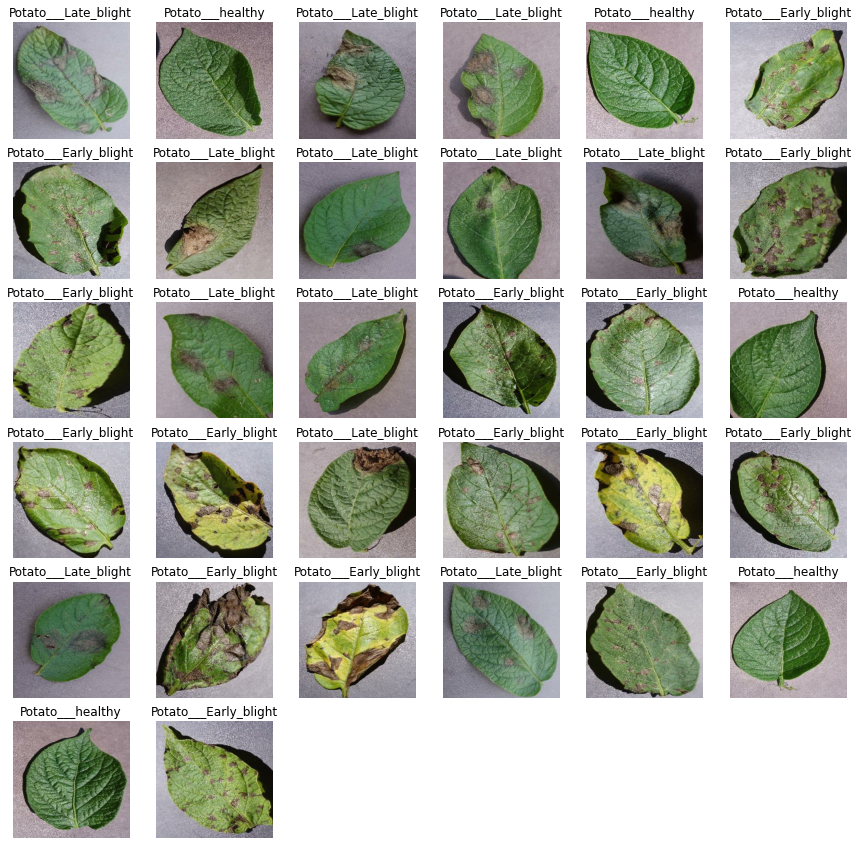

In [7]:
plt.figure(figsize=(15, 15))

for image_batch, label_batch in dataset.take(1):
    for i in range(CFG.batch_size):
        plt.subplot(6, 6, i+1)
        plt.imshow(image_batch[i].numpy().astype(int))
        plt.title(dataset.class_names[label_batch[i].numpy()])
        plt.axis('off')

In [8]:
# data preperation
## 80% training, 10% validation, 10% testing
size = len(dataset)
train_dataset = dataset.take(int(0.8*size))
val_dataset = dataset.take(int(0.9*size)).skip(int(0.8*size))
test_dataset = dataset.skip(int(0.9*size))

print(len(train_dataset), len(val_dataset), len(test_dataset))

54 7 7


In [9]:
# prefetch data batch prior to training 
train_dataset = train_dataset.cache().prefetch(buffer_size=tf.data.AUTOTUNE)
val_dataset = val_dataset.cache().prefetch(buffer_size=tf.data.AUTOTUNE)
test_dataset = test_dataset.cache().prefetch(buffer_size=tf.data.AUTOTUNE)

In [10]:
# rescaling and resizing
rescale_resize = tf.keras.Sequential([
    layers.experimental.preprocessing.Resizing(CFG.image_size[0], CFG.image_size[1]),
    layers.experimental.preprocessing.Rescaling(1/255)
])

In [11]:
# data augmentation
augment = tf.keras.Sequential([
    layers.experimental.preprocessing.RandomFlip('horizontal_and_vertical'),
    layers.experimental.preprocessing.RandomRotation(0.2),
    layers.experimental.preprocessing.RandomContrast(0.1)
])

# Model building

In [12]:
input_shape = (CFG.batch_size, CFG.image_size[0], CFG.image_size[1], CFG.channels)

model = models.Sequential([
    rescale_resize,
    augment,
    layers.Conv2D(32, (3,3), activation = 'relu', input_shape = input_shape),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, (3,3), activation = 'relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, (3,3), activation = 'relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, (3,3), activation = 'relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, (3,3), activation = 'relu'),
    layers.MaxPooling2D((2,2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(len(dataset.class_names), activation='softmax')
])

model.build(input_shape=input_shape)

In [13]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (32, 256, 256, 3)         0         
                                                                 
 sequential_1 (Sequential)   (None, 256, 256, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 254, 254, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 127, 127, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 125, 125, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 62, 62, 64)       0         
 2D)                                                  

In [14]:
model.compile(
    optimizer = 'adam',
    loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [15]:
history = model.fit(
    train_dataset,
    epochs=CFG.epochs,
    verbose=1,
    validation_data=val_dataset
)

Epoch 1/30
54/54 [==============================] - 205s 3s/step - loss: 0.8261 - accuracy: 0.5590 - val_loss: 1.2009 - val_accuracy: 0.6473
Epoch 2/30
54/54 [==============================] - 148s 3s/step - loss: 0.4691 - accuracy: 0.8252 - val_loss: 0.4262 - val_accuracy: 0.8795
Epoch 3/30
54/54 [==============================] - 151s 3s/step - loss: 0.3753 - accuracy: 0.8530 - val_loss: 0.4044 - val_accuracy: 0.8214
Epoch 4/30
54/54 [==============================] - 159s 3s/step - loss: 0.2685 - accuracy: 0.8883 - val_loss: 0.2523 - val_accuracy: 0.8884
Epoch 5/30
54/54 [==============================] - 200s 4s/step - loss: 0.2366 - accuracy: 0.8999 - val_loss: 0.1989 - val_accuracy: 0.9241
Epoch 6/30
54/54 [==============================] - 286s 5s/step - loss: 0.2015 - accuracy: 0.9230 - val_loss: 0.2426 - val_accuracy: 0.9062
Epoch 7/30
54/54 [==============================] - 212s 4s/step - loss: 0.1652 - accuracy: 0.9381 - val_loss: 0.2126 - val_accuracy: 0.9152
Epoch 8/30
54

In [16]:
scores = model.evaluate(test_dataset)
scores

7/7 [==============================] - 30s 383ms/step - loss: 0.0952 - accuracy: 0.9650


[0.09519895911216736, 0.9649999737739563]

In [17]:
history.params

{'verbose': 1, 'epochs': 30, 'steps': 54}

In [18]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

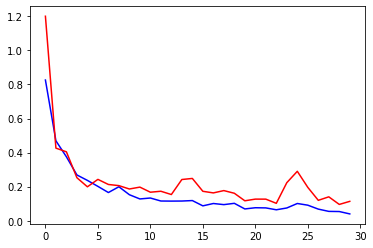

In [19]:
plt.plot(history.history['loss'], c = 'b')
plt.plot(history.history['val_loss'], c ='r')
plt.show()

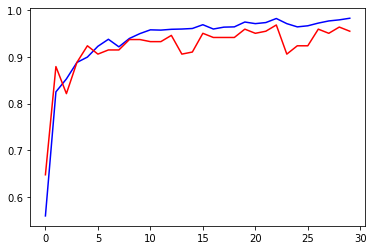

In [20]:
plt.plot(history.history['accuracy'], c = 'b')
plt.plot(history.history['val_accuracy'], c ='r')
plt.show()

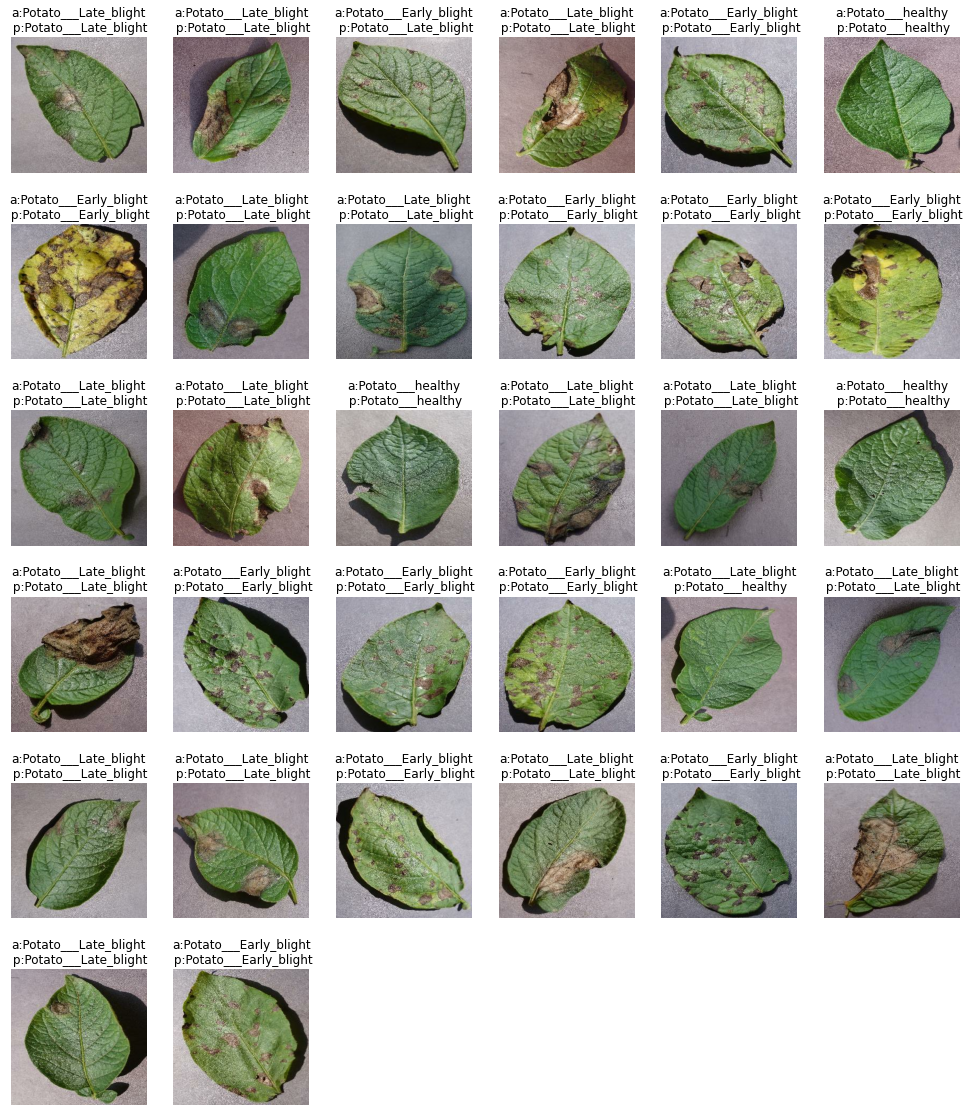

In [22]:
batch_no = 1
plt.figure(figsize=(17, 20))

for batch_image, batch_label in test_dataset.take(batch_no):
    predict_batch = model.predict(batch_image, verbose=0)
    for i in range(CFG.batch_size):
        ax = plt.subplot(6, 6, i+1)
        plt.imshow(batch_image[i].numpy().astype('uint8'))
        plt.axis('off')
        
        actual_label = class_names[batch_label[i].numpy()]
        predict_label = class_names[np.argmax(predict_batch[i])]
        plt.title("a:{}\n p:{}".
                  format(actual_label, predict_label))

In [23]:
all_version = [int(i) for i in os.listdir('models')] + [0]
model_version = max(all_version) + 1
model.save(f"models/{model_version}")

INFO:tensorflow:Assets written to: models/3\assets


INFO:tensorflow:Assets written to: models/3\assets
